In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from scmcallib.scm import get_scm

In [2]:
# small sample size for testing, increase for real results
samples = 100
gmt_file = "../tests/test_data/HadCRUT.4.6.0.0.annual_ns_avg_clean.csv"

# the observable we want calibrate to:
# global mean temperature from 1850 to 2017
# we use the last year of observations as the reference year here.
observed_gmt = pd.read_csv(gmt_file, index_col=0)
observed_gmt.index = [int(i.split("-")[0]) for i in observed_gmt.index.values]
observed_gmt -= observed_gmt.loc[2017]
# make it a numpy array
observed_gmt_for_pymc3 = np.squeeze(observed_gmt.loc[1850:2017].values)

"""
Set up the priors
"""
best_guess_c1 = 0.631
best_guess_c2 = 1
best_guess_a1 = 0.2240

In [3]:
sample_prior_pred = True
n_prior_samples = 200

# Note this + the tuning number (50 right now) will be multiplied by however many chains
n_draws = 1000

with pm.Model() as model:
    
    param_list = [
        pm.Bound(pm.Normal, lower=0.1)('c1', mu=best_guess_c1, sd=1.),
        pm.Bound(pm.Normal, lower=0.1)('c2', mu=best_guess_c2, sd=1.),
        pm.Bound(pm.Normal, lower=0.1, upper=0.4)('a1', mu=best_guess_a1, sd=0.1)
    ]
    
    # Letting the noise be a free random variable is super nice, it let's
    # the uncertainty in the data "speak for itself" - see plots below
    noise = pm.Gamma('noise', alpha=2, beta=1)
    
    y_mu = PyMC3Runner('ar5ir', param_list)() # See google doc on why this is "mu"
    
    y_observed = pm.Normal(
        'y_observed',
        mu=y_mu, 
        sd=noise,
        observed=observed_gmt_for_pymc3)
    
    if sample_prior_pred is True:
        prior_pred = pm.sample_prior_predictive(samples=n_prior_samples)
    
    posterior = pm.sample(draws=n_draws, tune=50, chains=3, live_plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (3 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Slice: [a1]
>>Slice: [c2]
>>Slice: [c1]
>NUTS: [noise]
Sampling 3 chains: 100%|██████████| 3150/3150 [04:22<00:00, 10.10draws/s]
The acceptance probability does not match the target. It is 0.9452297609082047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9249856457143402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9386799271635968, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameter

/Users/nicholashirons/anaconda/envs/scmcallib/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


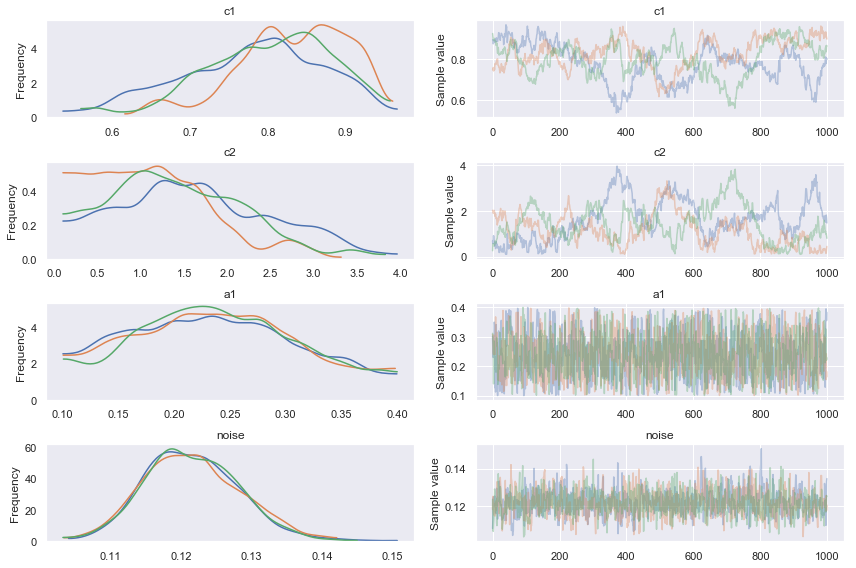

In [4]:
# Note the additional noise term plot, since we are setting this as a free RV
pm.traceplot(posterior)
plt.show()

In [5]:
pm.summary(posterior)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
c1     0.802390  0.084318  0.007887  0.642680  0.949803    27.758416  1.053512
c2     1.408585  0.802562  0.075023  0.100184  2.921460    27.770554  1.053258
a1     0.238518  0.073751  0.002020  0.100573  0.367833  1315.283367  0.999930
noise  0.121488  0.006701  0.000191  0.108966  0.134762  1013.906033  0.999518

In [6]:
# Note the sample_pcc method is being depracated to sample_posterior_predictive
posterior_pred = pm.sample_ppc(
    trace=posterior,
    model=model,
    samples=1000)

100%|██████████| 1000/1000 [00:10<00:00, 97.07it/s]


In [7]:
# Each row is a sample predictive output, based on a sample of parameters from the posteriors.
posterior_pred['y_observed'].shape

(1000, 168)

In [8]:
# Here we just get a plot of what the outputs would look like using our parameter prior means
prior_mean_params = {
    'c1': best_guess_c1,
    'c2': best_guess_c2,
    'a1': best_guess_a1
}
scm = get_scm('ar5ir')()
results = scm.run(**prior_mean_params)
prior_predictive_mean = scm.process_results(results)

# We also have the samples from the prior_pred that we can plot, but here we just want
# a single plot rather than samples.

In [9]:
# This is the mean of the samples, not the precise posterior predictive mean from the MAP estimate.
# This is why the plot wiggles when, currently, it should be a smooth predictive mean.
post_pred_mu = posterior_pred['y_observed'].mean(axis=0)
post_pred_sd = posterior_pred['y_observed'].std(axis=0)

# I think these are what we call "credible intervals", the Bayesian version 
# of confidence intervals. Not sure if the values of the 95% credible interval
# are different so I just rounded 1.96 (from frequentist) to 2.

post_pred_upper = posterior_pred['y_observed'].mean(axis=0) + 2 * post_pred_sd
post_pred_lower = posterior_pred['y_observed'].mean(axis=0) - 2 * post_pred_sd

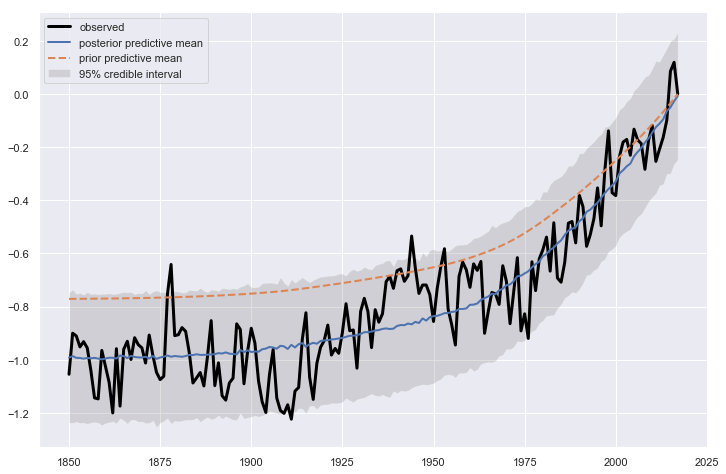

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

ax.fill_between(
    np.arange(1850, 2018),
    post_pred_lower,
    post_pred_upper,
    label="95% credible interval",
    facecolor='grey',
    alpha=0.25
)
ax.plot(
    np.arange(1850, 2018),
    observed_gmt_for_pymc3,
    color='black',
    linewidth=3,
    label='observed'
)
ax.plot(
    np.arange(1850, 2018),
    post_pred_mu,
    linewidth=2,
    label="posterior predictive mean"
)
ax.plot(
    np.arange(1850, 2018),
    prior_predictive_mean,
    '--',
    linewidth=2,
    label="prior predictive mean"
)
#prior_pred['y_observed'].mean(axis=0))
ax.legend()

plt.show()